In [179]:
import re
import numpy as np
import pandas as pd
import datetime as dt
import gc
import random
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB    


dis_path = './data/us_disaster_declarations.csv'
temp_path = './data/GlobalLandTemperaturesByState.csv'
states_path = './data/states.csv'

# load list of states
states = {}
with open(states_path) as f:
    next(f)

    for line in f:
        l = line.split(',')
        states[l[0].strip()] = l[1].strip()

# print(states)

# filter disaster dataset
dis_data = pd.read_csv(dis_path)[['state', 'declaration_date', 'incident_type','declaration_title']].rename({'declaration_date': 'date'}, axis=1)
dis_data['date'] = dis_data['date'].astype('datetime64[ns]').dt.strftime('%m-%Y')
dis_data = dis_data.drop_duplicates(subset=['incident_type', 'declaration_title', 'date', 'state'], keep='first')
# dis_data = dis_data.groupby(['state', 'date']).count()
dis_data['disaster_type'] = dis_data['incident_type']
dis_data = dis_data.rename({'incident_type': 'disaster_occurrence'}, axis=1)
dis_data['disaster_occurrence'] = np.ones(dis_data['disaster_occurrence'].shape)
# dis_data = dis_data.reset_index()

# print(dis_data)

dis_data.to_csv('./data/test_disasters_state_month.csv', index=False)

# filter temperature dataset
temp_data = pd.read_csv(temp_path)
temp_data = temp_data[temp_data['Country'] == 'United States'].dropna()  # filter by United States, remove NaNs
temp_data['date'] = temp_data['dt'].astype('datetime64[ns]').dt.strftime('%m-%Y')  # convert string to date, then convert to year
temp_data['state'] = temp_data['State'].apply(lambda x: states[x] if x in states else None)  # preprocess state strings
temp_data = temp_data.dropna()
temp_data = temp_data.groupby(['date', 'state'])  # group by year then state
temp_data = temp_data[['AverageTemperature', 'AverageTemperatureUncertainty']].mean().reset_index()  # take average over groups

# print(temp_data)

temp_data.to_csv('./data/test_temp_state_month.csv', index=False)

# join on `Year` and `State`
df = pd.merge(temp_data, dis_data, on=['date', 'state'], how='left').set_index(['date', 'state'], drop=True)
df.rename({'AverageTemperature': 'ave_temp', 'AverageTemperatureUncertainty': 'ave_temp_uncertainty'}, axis=1, inplace=True)
df = df.fillna(0).reset_index()
df['month'] = df['date'].astype('datetime64[ns]').dt.strftime('%m')
df['year'] = df['date'].astype('datetime64[ns]').dt.strftime('%Y')
df['date'] = pd.to_datetime(df.date)


df.to_csv('./data/test_disasters_temp_state_month.csv', index=False)

df['y_data'] = df['disaster_occurrence']
df = df.drop(['disaster_occurrence'], axis=1)


df = df[df.year > "1960"]
df = df.drop(['year'], axis=1)

df = df.sort_values(by=['date'])
x_data = df.iloc[:,0:-1]
y_data = df.iloc[:,-1]






In [ ]:
df = df.drop(['declaration_title','disaster_type'], axis=1)

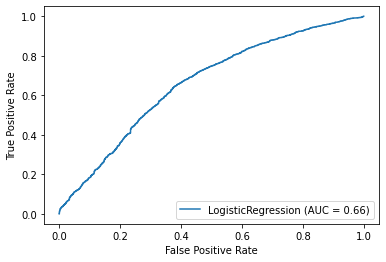

In [216]:


train_rows = int(0.6 * x_data.shape[0])
test_rows = x_data.shape[0] - train_rows# - train_rows

x_train = df.iloc[:train_rows, 0:-1]
y_train = df.iloc[:train_rows, -1]
x_test = df.iloc[train_rows:, 0:-1]
y_test = df.iloc[train_rows:, -1]
    
X = x_data.iloc[:,2:]
y = y_data

x_test_plot = x_test.iloc[:,2:]


In [ ]:

logR = LogisticRegression()
logR.fit(x_train.iloc[:,2:], y_train)
y_predict_test = logR.predict_proba(x_test.iloc[:,2:])
y_predict_train = logR.predict_proba(x_train.iloc[:,2:])

y_predict_test = y_predict_test[:,1:]

plot_roc_curve(logR, x_test_plot, y_test)  

x_test['Disaster_Prob'] = y_predict_test
x_test['y_data'] = y_data

test_df = pd.DataFrame(y_predict_test, columns = ['Y_predict'])

test_actual = df.iloc[test_rows:,:]

test_actual=test_actual[['date', 'state', 'y_data']]
LogisticRegression_Test_Per = x_test[['date', 'state', 'Disaster_Prob']]
logResgressionPerTestCombined = x_test[['date', 'state', 'Disaster_Prob', 'y_data']]


logResgressionPerTestCombined.to_csv('./data/logResgressionPerTestCombined.csv', index=False)                        
test_actual.to_csv('./data/test_actual.csv', index=False)
LogisticRegression_Test_Per.to_csv('./data/logRPredictTest.csv', index=False)  


In [201]:


roc = []

threshold = 0
y_test = y_test.reset_index(drop=True)

for i in range(0,25):
    y_predict_test_no_prob = np.where(y_predict_test >= threshold, 1, 0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_no_prob).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    
    roc.append([threshold, tn, fp, fn, tp, fpr, tpr])
    threshold = threshold + .005

roc_df = pd.DataFrame(roc, columns =['Threshold', 'tn', 'fp', 'fn', 'tp','fpr', 'tpr']) 
print(roc_df)
roc_df.to_csv('./data/prc_df.csv', index=False) 


    Threshold     tn     fp    fn    tp       fpr       tpr
0       0.000      0  10450     0  2237  1.000000  1.000000
1       0.005      0  10450     0  2237  1.000000  1.000000
2       0.010      5  10445     0  2237  0.999522  1.000000
3       0.015     46  10404     7  2230  0.995598  0.996871
4       0.020    287  10163    19  2218  0.972536  0.991506
5       0.025    773   9677    54  2183  0.926029  0.975861
6       0.030   1403   9047   101  2136  0.865742  0.954850
7       0.035   2145   8305   169  2068  0.794737  0.924452
8       0.040   3008   7442   259  1978  0.712153  0.884220
9       0.045   3893   6557   358  1879  0.627464  0.839964
10      0.050   4862   5588   519  1718  0.534737  0.767993
11      0.055   5750   4700   653  1584  0.449761  0.708091
12      0.060   6690   3760   864  1373  0.359809  0.613768
13      0.065   7604   2846  1141  1096  0.272344  0.489942
14      0.070   8376   2074  1447   790  0.198469  0.353152
15      0.075   9032   1418  1690   547 

In [220]:
GNBclf = GaussianNB()
GNBclf.fit(x_train.iloc[:,2:], y_train)
y_predict_test_GNB = GNBclf.predict_proba(x_test_plot)
y_predict_train_GNB = GNBclf.predict_proba(x_train.iloc[:,2:])

y_predict_test_GNB = y_predict_test_GNB[:,1:]
y_predict_test_GNB = np.round(y_predict_test_GNB, 5)
test_df_GNB = pd.DataFrame(y_predict_test_GNB, columns = ['Y_predict'])
test_df_GNB.to_csv('./data/test_df_GNB.csv', index=False)

from sklearn.metrics import confusion_matrix, plot_roc_curve

roc_GNB = []

threshold = 0
y_test = y_test.reset_index(drop=True)

for i in range(0,25):
    y_predict_test_no_prob = np.where(y_predict_test_GNB >= threshold, 1, 0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_no_prob).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    
    roc_GNB.append([threshold, tn, fp, fn, tp, fpr, tpr])
    threshold = threshold + .005

roc_GNB_df = pd.DataFrame(roc_GNB, columns =['Threshold', 'tn', 'fp', 'fn', 'tp','fpr', 'tpr']) 
print(roc_GNB_df)
roc_GNB_df.to_csv('./data/prc_GNB_df.csv', index=False) 





    Threshold     tn     fp    fn    tp       fpr       tpr
0       0.000      0  10450     0  2237  1.000000  1.000000
1       0.005     76  10374    11  2226  0.992727  0.995083
2       0.010    176  10274    25  2212  0.983158  0.988824
3       0.015    469   9981    45  2192  0.955120  0.979884
4       0.020    914   9536    77  2160  0.912536  0.965579
5       0.025   1480   8970   129  2108  0.858373  0.942333
6       0.030   2111   8339   183  2054  0.797990  0.918194
7       0.035   2700   7750   241  1996  0.741627  0.892266
8       0.040   3282   7168   301  1936  0.685933  0.865445
9       0.045   3902   6548   386  1851  0.626603  0.827447
10      0.050   4489   5961   479  1758  0.570431  0.785874
11      0.055   5062   5388   567  1670  0.515598  0.746536
12      0.060   5589   4861   747  1490  0.465167  0.666071
13      0.065   6233   4217   883  1354  0.403541  0.605275
14      0.070   6979   3471  1046  1191  0.332153  0.532409
15      0.075   7862   2588  1329   908 

In [225]:

svc_clf = SVC(probability=True)
svc_clf.fit(x_train.iloc[:,2:], y_train)
y_predict_test_SVC = svc_clf.predict_proba(x_test_plot)

y_predict_test_SVC = y_predict_test_SVC[:,1:]


test_df_SVC = pd.DataFrame(y_predict_test_SVC, columns = ['Y_predict'])
test_df_SVC.to_csv('./data/test_df_SVC.csv', index=False)

from sklearn.metrics import confusion_matrix, plot_roc_curve

roc_SVC = []

threshold = 0
y_test = y_test.reset_index(drop=True)

for i in range(0,25):
    y_predict_test_no_prob = np.where(y_predict_test_SVC >= threshold, 1, 0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_no_prob).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    
    roc_SVC.append([threshold, tn, fp, fn, tp, fpr, tpr])
    threshold = threshold + .005

roc_SVC_df = pd.DataFrame(roc_SVC, columns =['Threshold', 'tn', 'fp', 'fn', 'tp','fpr', 'tpr']) 
print(roc_SVC_df)
roc_SVC_df.to_csv('./data/prc_SVC_df.csv', index=False) 


    Threshold     tn     fp    fn    tp       fpr       tpr
0       0.000      0  10450     0  2237  1.000000  1.000000
1       0.005      0  10450     0  2237  1.000000  1.000000
2       0.010      0  10450     0  2237  1.000000  1.000000
3       0.015      0  10450     0  2237  1.000000  1.000000
4       0.020      0  10450     0  2237  1.000000  1.000000
5       0.025      0  10450     0  2237  1.000000  1.000000
6       0.030      0  10450     0  2237  1.000000  1.000000
7       0.035      0  10450     0  2237  1.000000  1.000000
8       0.040      0  10450     0  2237  1.000000  1.000000
9       0.045      0  10450     0  2237  1.000000  1.000000
10      0.050    235  10215    40  2197  0.977512  0.982119
11      0.055   8157   2293  1838   399  0.219426  0.178364
12      0.060   9981    469  2131   106  0.044880  0.047385
13      0.065  10447      3  2194    43  0.000287  0.019222
14      0.070  10449      1  2221    16  0.000096  0.007152
15      0.075  10449      1  2234     3 